# Assignment 1 by Magnus Nytun

### Short report 
I am using pytorch and google colab to answer this assignment. 

#### Data
First I started with finding a way to read in image data to Google colab. The solution was to upload the data as a zip file and unzip it. 

I continued to plot some of the images. I noticed that the images in each class seemed to be very uniform. They were for the most part in the center of the image and the colors didn't vary much. Some times the animal was facing different directions, and the animals also varied in size. 

The data was labeled as follows:  <br>

| Animal   | label |
|----------|-------|
| Elephant | 0     |
| giraffe  | 1     |
| lion     | 2     |
| zebra    | 3     |


### ANN 
First I tried making the smallest possible network. This was because I thought that the data would be easy to learn for the model. I realized the model needed alot of epochs to get satisfactory results. I then decided to increase the out shape of the first layer from 512 to 1024 parameters. I also added dropout to avoid overfitting. The model converged, but it still needed alot of epochs. 

The ANN is ok, but the evaluation score is unstable. Test results are good.  

### CNN 
I made the CNN after the recipe given to me. I trained the network and it converged much faster than the ANN. The ANN needed 130 epochs, and still the evaluation score wasn't stable. The CNN converged in only 30 epochs with perfect evaluation score. Metrics from testset couldn't be better, with perfect score on all of the metrics. 

#### Read and prep data for exploration and training 

In [ ]:
# for uploading imgs to google colab
from google.colab import files
uploaded = files.upload()

!unzip safari.zip

In [ ]:
import os
import numpy as np
import torch
from torch import nn
import torchvision
import PIL
import pandas as pd
from torchvision.io import read_image
import torchvision.transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# preparing data for exploration and training 
elephant_folder = "safari/training/elephant"
giraffe_folder = "safari/training/giraffe"
lion_folder = "safari/training/lion"
zebra_folder = "safari/training/zebra"

# class to in mapping 
# elephant = 0
# giraffe = 1
# lion = 2
# zebra = 3

eleph = [(0 ,read_image(os.path.join(elephant_folder, o))) for o in os.listdir(elephant_folder)]
gir = [(1 ,read_image(os.path.join(giraffe_folder, o))) for o in os.listdir(giraffe_folder)]
lion = [(2 ,read_image(os.path.join(lion_folder, o))) for o in os.listdir(lion_folder)]
zebra = [(3 ,read_image(os.path.join(zebra_folder, o))) for o in os.listdir(zebra_folder)]

In [ ]:
val_set = []
val_set.append(eleph.pop(0))
val_set.append(gir.pop(0))
val_set.append(lion.pop(0))
val_set.append(zebra.pop(0))

In [ ]:
train_set = eleph + gir + lion + zebra

In [ ]:
target_mapper = {
  "giraffe" : 1,
  "elephant" : 0,
  "lion" : 2,
  "zebra" : 3
}

test_set = []
test_dir = "safari/test"

for f in os.listdir(test_dir):
  target = target_mapper[f.split(".")[0]]
  test_set.append((target, read_image(os.path.join(test_dir, f))))

In [ ]:
class ZooDataset(Dataset):
    def __init__(self, class_tensor):
      self.class_tensor = class_tensor
      
    def __len__(self):
        return len(self.class_tensor)

    def __getitem__(self, idx):
        image = self.class_tensor[idx][1]
        label = self.class_tensor[idx][0]
        return label, image

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=4, shuffle=True)

#### Explore data

Feature batch shape: torch.Size([64, 3, 200, 200])
Labels batch shape: torch.Size([64])


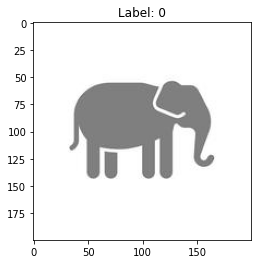

In [ ]:
train_labels, train_features = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

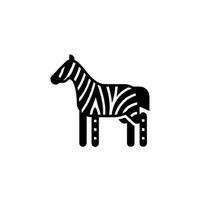

In [ ]:
torchvision.transforms.ToPILImage()(zebra[5][1])

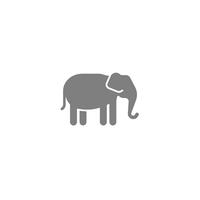

In [ ]:
torchvision.transforms.ToPILImage()(eleph[5][1])

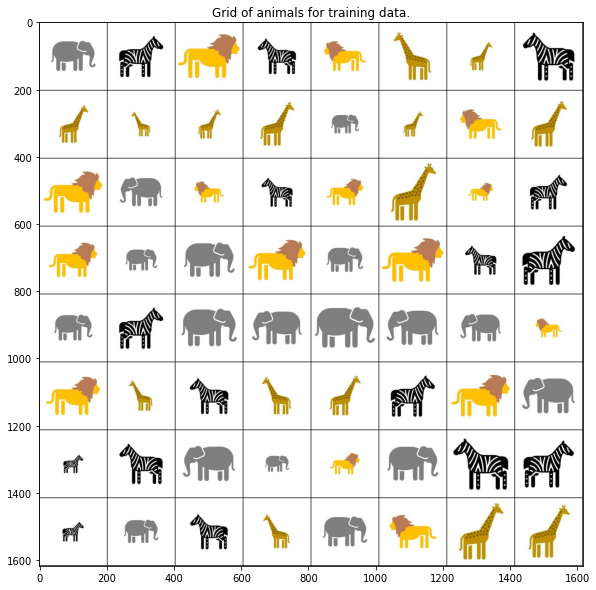

In [ ]:
grids = torchvision.utils.make_grid(train_features)
grids_ = grids.permute(1, 2, 0)
plt.figure(figsize = (25,10))
plt.title("Grid of animals for training data.")
plt.imshow(grids_)

Now that you've ploted some of the images, so use your preferred framework (PyTorch or TensorFlow) to train both ANN and CNN classifiers for them. Your goal is to train a classifier with a validation accuracy of 95% or higher.

# ANN Model

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self) -> None:
     super().__init__()
     self.flatten = nn.Flatten()
     self.network = nn.Sequential(
         nn.Linear(3*200*200, 1024),
         nn.ReLU(),
         nn.Dropout(),
         nn.Linear(1024, 512),
         nn.ReLU(),
         nn.Linear(512, 4)
     )

  def forward(self, x):
    x = self.flatten(x)
    x = torch.div(x, 255)
    logits = self.network(x)
    return logits 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNetwork().to(device)

Using cuda device


In [ ]:
learning_rate = 1e-4
batch_size = 64
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def accuracy(y_pred, y):
  y_pred = y_pred.argmax(axis=1)
  acc = sum(y_pred == y) / len(y)
  return acc

In [ ]:
def train_model(epochs, dataloader, model, loss_fn, 
                optimizer, eval_func, val_dataloader):  
  batch_loss = []
  eval_scores = []

  for e in range(epochs):
    size = len(dataloader.dataset)

    for batch, (y, X) in enumerate(dataloader):
        y = y.to(device)
        X = X.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
      
        batch_loss.append(loss)

        y_val, X_val = next(iter(val_dataloader))

        with torch.no_grad():
          X_val = X_val.to(device)
          y_val = y_val.to(device)
          val_preds = model(X_val)
          
          eval_score = eval_func(val_preds, y_val)
          eval_scores.append(eval_score)

    if e % 10 == 0:
      print(f"""----------------------
      Epoch: {e} 
        Mean loss: {np.mean(batch_loss):.3f} 
        Accuracy {eval_score.item():.3f}""")
        
  return batch_loss, eval_scores

In [ ]:
batch_loss, eval_scores = train_model(130, train_dataloader, model, loss_fn, 
                                      optimizer, accuracy, val_dataloader)

----------------------
      Epoch: 0 
        Mean loss: 2.609 
        Accuracy 0.250
----------------------
      Epoch: 10 
        Mean loss: 1.207 
        Accuracy 1.000
----------------------
      Epoch: 20 
        Mean loss: 0.843 
        Accuracy 0.750
----------------------
      Epoch: 30 
        Mean loss: 0.660 
        Accuracy 1.000
----------------------
      Epoch: 40 
        Mean loss: 0.529 
        Accuracy 1.000
----------------------
      Epoch: 50 
        Mean loss: 0.444 
        Accuracy 1.000
----------------------
      Epoch: 60 
        Mean loss: 0.380 
        Accuracy 1.000
----------------------
      Epoch: 70 
        Mean loss: 0.334 
        Accuracy 1.000
----------------------
      Epoch: 80 
        Mean loss: 0.297 
        Accuracy 1.000
----------------------
      Epoch: 90 
        Mean loss: 0.268 
        Accuracy 1.000
----------------------
      Epoch: 100 
        Mean loss: 0.243 
        Accuracy 1.000
---------------------

### Loss for ANN

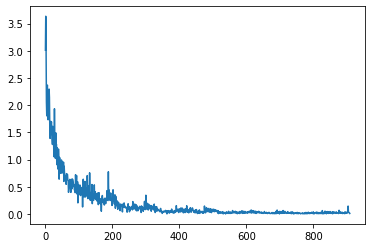

In [ ]:
plt.plot(batch_loss)

### Eval score for ANN 

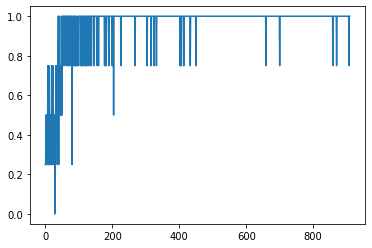

In [ ]:
plt.plot([e.item() for e in eval_scores])

In [ ]:
y_test, X_test = next(iter(test_dataloader))
with torch.no_grad():
          X_test = X_test.to(device)
          y_test = y_test.to(device)
          test_preds = model(X_test)

In [ ]:
y_test = y_test.to("cpu")

In [ ]:
test_preds = test_preds.argmax(axis=1).to("cpu")

In [ ]:
confusion_matrix(y_test.numpy(), test_preds.numpy())

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [ ]:
print(classification_report(y_test.numpy(), test_preds.numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



# CNN Model

In [ ]:
# import libraries here and define CNN

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.flatten = nn.Flatten()

    self.conv = nn.Sequential(
        nn.Conv2d(
            in_channels = 3,
            out_channels = 32, # n filters
            kernel_size = (6,6)
        ), 
        # output shape: batch_size X 32 X H_out X W_out
        # H_out = W_out = ((200 - 1 * 5) - 1) + 1 = 195
        nn.ReLU(),

        nn.MaxPool2d((2,2)), # kernel = (2,2) 
        # input: BATCH_SIZE X 32 X H_out x W_out 
        # H_out = W_out = 97

        nn.Conv2d(
            in_channels = 32, 
            out_channels = 32, 
            kernel_size = (6,6)
        ),
        # output shape: batch_size X 32 X H_out X W_out
        # H_out = W_out = 92
        nn.ReLU(),

        nn.MaxPool2d((2,2)), # kernel = (2,2) 
        # input: BATCH_SIZE X 32 X H_out x W_out 
        # H_out = W_out = 46

        nn.Conv2d(
            in_channels = 32, 
            out_channels = 128, 
            kernel_size = (3,3)
        ),
        # output shape: batch_size X 128 X H_out X W_out
        # H_out = W_out = 45
        nn.ReLU(),

        nn.Conv2d(
            in_channels = 128,
            out_channels = 32, 
            kernel_size = (6,6)
        ),
        # output shape: batch_size X 32 X H_out X W_out
        # H_out = W_out = 43
        nn.ReLU(),

    )

    self.linear = nn.Sequential( 
        # in -> batch_size X 32 X 39 X 39
        # after flatten: 32 * 39 * 39 = 48,672
        nn.Linear(
            in_features = 48672,
            out_features = 4,
        ),
        nn.Softmax()
    )

  def forward(self, x):
    x = torch.div(x, 255)
    x = self.conv(x)
    x = self.flatten(x)
    probas = self.linear(x)
    return probas


In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = CNN().to(device)

Using cuda device


In [ ]:
learning_rate = 1e-3
batch_size = 64
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train your model
batch_loss, eval_scores = train_model(30, train_dataloader, model, loss_fn, 
                                      optimizer, accuracy, val_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------
      Epoch: 0 
        Mean loss: 1.407 
        Accuracy 0.500
----------------------
      Epoch: 10 
        Mean loss: 0.903 
        Accuracy 1.000
----------------------
      Epoch: 20 
        Mean loss: 0.827 
        Accuracy 1.000


In [ ]:
for y, X in test_dataloader:
  X = X.to(device)
  preds = model(X)

In [ ]:
y_pred = preds.argmax(axis=1).to("cpu").numpy()

In [ ]:
y = y.to("cpu").numpy()

In [ ]:
# Plot the loss history of both training and validation (Model Accuracu and Model loss)

### Loss for CNN

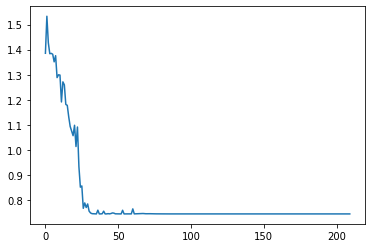

In [ ]:
plt.plot(batch_loss)

### Validation score for CNN

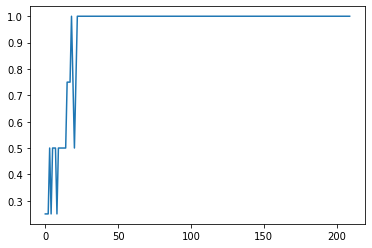

In [ ]:
plt.plot([e.item() for e in eval_scores])

In [ ]:
# Evaluate model performance

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
confusion_matrix(y, y_pred)

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [ ]:
# save your model
torch.save(model.state_dict(), "cnn_fitted")

In [ ]:
# Use the trained model
model = CNN()
model.load_state_dict(torch.load("cnn_fitted"))
model.eval()

X = X.to("cpu")
preds = model(X)

In [ ]:
preds.argmax(axis=1).numpy() == y

array([ True,  True,  True,  True])